# *SOURCE*
https://www.youtube.com/watch?v=doDUihpj6ro&t=7339s
https://github.com/nicknochnack/ActionDetectionforSignLanguage

In [1]:
! pip install PyQt5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.8/357.8 KB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 11.1 MB/s eta 0:00:00


In [2]:
!pip install tensorflow==2.8.1 tensorflow-gpu==2.8.1 opencv-python mediapipe 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 50.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully un

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [4]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('/content/Tutorial_LSTM_MP/Complete_CheatDataNiko') 

# Actions that we try to detect
actions = np.array(['LirikKanan', 'LirikKiri', 'MenolehKanan', 'MenolehKiri', 'Normal', 'TutupMata'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 50

In [5]:
! git clone https://github.com/nickbp760/Tutorial_LSTM_MP.git

Cloning into 'Tutorial_LSTM_MP'...
remote: Enumerating objects: 37875, done.
remote: Counting objects: 100% (14863/14863), done.
remote: Compressing objects: 100% (10166/10166), done.
remote: Total 37875 (delta 4699), reused 14854 (delta 4691), pack-reused 23012
Receiving objects: 100% (37875/37875), 631.10 MiB | 26.15 MiB/s, done.
Resolving deltas: 100% (4904/4904), done.
Updating files: 100% (31881/31881), done.


### **Preprocess Data and Create Labels and Features**

The label map containts the action label

In [6]:
label_map = {label:num for num, label in enumerate(actions)}

In [7]:
label_map

{'LirikKanan': 0,
 'LirikKiri': 1,
 'MenolehKanan': 2,
 'MenolehKiri': 3,
 'Normal': 4,
 'TutupMata': 5}

load the the data that have been prepared before

In [8]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [9]:
np.array(sequences).shape

(180, 50, 15)

DEFINE X (Input) and y (Output)

In [10]:
X = np.array(sequences)
print(X.shape)
y = to_categorical(labels).astype(int)
print(y.shape)

(180, 50, 15)
(180, 6)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [12]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    

### **Build and Train Neural Network**

In [13]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [31]:
model = Sequential()
model.add(GRU(128, return_sequences=True, activation='relu', input_shape=(50,15)))
model.add(GRU(64, return_sequences=True, activation='relu'))
model.add(GRU(128, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [32]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.optimizer.lr.assign(0.0001)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1e-04>

In [33]:
history = model.fit(X_train, y_train, epochs=100, callbacks=[tb_callback], validation_data = (X_test, y_test))

Epoch 1/100
6/6 [==============================] - 7s 672ms/step - loss: 1.7795 - categorical_accuracy: 0.1667 - val_loss: 1.7840 - val_categorical_accuracy: 0.2222
Epoch 2/100
6/6 [==============================] - 3s 477ms/step - loss: 1.7453 - categorical_accuracy: 0.3148 - val_loss: 1.7620 - val_categorical_accuracy: 0.2222
Epoch 3/100
6/6 [==============================] - 2s 344ms/step - loss: 1.7221 - categorical_accuracy: 0.3457 - val_loss: 1.7437 - val_categorical_accuracy: 0.2222
Epoch 4/100
6/6 [==============================] - 2s 326ms/step - loss: 1.7006 - categorical_accuracy: 0.3457 - val_loss: 1.7279 - val_categorical_accuracy: 0.2222
Epoch 5/100
6/6 [==============================] - 2s 338ms/step - loss: 1.6814 - categorical_accuracy: 0.3457 - val_loss: 1.7104 - val_categorical_accuracy: 0.2222
Epoch 6/100
6/6 [==============================] - 2s 324ms/step - loss: 1.6606 - categorical_accuracy: 0.3642 - val_loss: 1.6948 - val_categorical_accuracy: 0.2222
Epoch 7/10

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, 50, 128)           55680     
                                                                 
 gru_10 (GRU)                (None, 50, 64)            37248     
                                                                 
 gru_11 (GRU)                (None, 128)               74496     
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 6)                 198       
                                                                 
Total params: 177,958
Trainable params: 177,958
Non-tr

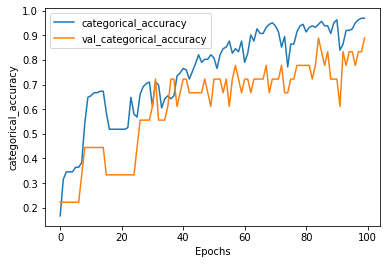

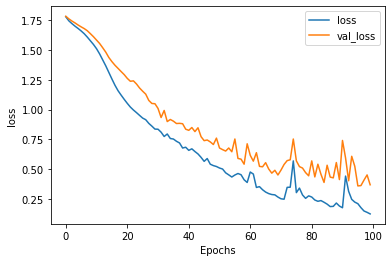

In [34]:
model.summary()
model.save('/content/Tutorial_LSTM_MP/Weight_model/actionGRUCheatData.h5')
plot_graphs(history, 'categorical_accuracy')
plot_graphs(history, 'loss')

In [36]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(50,15)))
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=False, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [37]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.optimizer.lr.assign(0.0001)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1e-04>

In [38]:
history = model.fit(X_train, y_train, epochs=200, callbacks=[tb_callback], validation_data = (X_test, y_test))

Epoch 1/200
6/6 [==============================] - 5s 346ms/step - loss: 1.8038 - categorical_accuracy: 0.0988 - val_loss: 1.7528 - val_categorical_accuracy: 0.2778
Epoch 2/200
6/6 [==============================] - 2s 281ms/step - loss: 1.7778 - categorical_accuracy: 0.2407 - val_loss: 1.7425 - val_categorical_accuracy: 0.4444
Epoch 3/200
6/6 [==============================] - 3s 583ms/step - loss: 1.7585 - categorical_accuracy: 0.3210 - val_loss: 1.7224 - val_categorical_accuracy: 0.4444
Epoch 4/200
6/6 [==============================] - 2s 369ms/step - loss: 1.7347 - categorical_accuracy: 0.3210 - val_loss: 1.6980 - val_categorical_accuracy: 0.5000
Epoch 5/200
6/6 [==============================] - 2s 280ms/step - loss: 1.7016 - categorical_accuracy: 0.4321 - val_loss: 1.6704 - val_categorical_accuracy: 0.5000
Epoch 6/200
6/6 [==============================] - 2s 257ms/step - loss: 1.6481 - categorical_accuracy: 0.5185 - val_loss: 1.6208 - val_categorical_accuracy: 0.5000
Epoch 7/20

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50, 128)           73728     
                                                                 
 lstm_4 (LSTM)               (None, 50, 64)            49408     
                                                                 
 lstm_5 (LSTM)               (None, 128)               98816     
                                                                 
 dense_15 (Dense)            (None, 128)               16512     
                                                                 
 dense_16 (Dense)            (None, 32)                4128      
                                                                 
 dense_17 (Dense)            (None, 6)                 198       
                                                                 
Total params: 242,790
Trainable params: 242,790
Non-tr

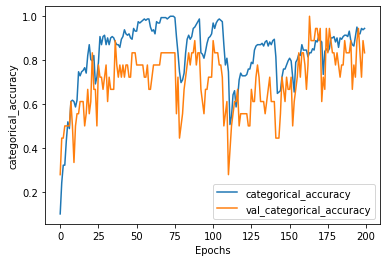

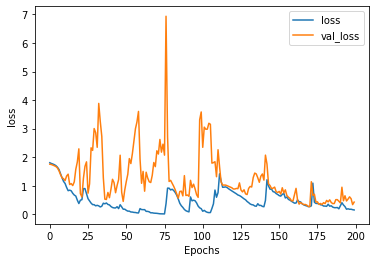

In [40]:
model.summary()
model.save('/content/Tutorial_LSTM_MP/Weight_model/actionLSTMCheatData.h5')
plot_graphs(history, 'categorical_accuracy')
plot_graphs(history, 'loss')